# Emulation

### [Neil D. Lawrence](http://inverseprobability.com), University of

Cambridge

### 2022-10-20

**Abstract**: In this lecture we motivate the use of emulation, and
introduce the GPy software as a framework for building Gaussian process
emulators.

$$
$$

::: {.cell .markdown}

<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!---->
<!-- Do not edit this file locally. -->
<!-- Do not edit this file locally. -->
<!-- The last names to be defined. Should be defined entirely in terms of macros from above-->
<!--

-->

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

<!--setupplotcode{import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('paper')
sns.set_palette('colorblind')}-->

## notutils

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/notutils-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/notutils-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

This small package is a helper package for various notebook utilities
used

The software can be installed using

In [2]:
%pip install notutils

Note: you may need to restart the kernel to use updated packages.


from the command prompt where you can access your python installation.

The code is also available on GitHub:
<https://github.com/lawrennd/notutils>

Once `notutils` is installed, it can be imported in the usual manner.

In [3]:
import notutils

## mlai

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/mlai-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/mlai-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The `mlai` software is a suite of helper functions for teaching and
demonstrating machine learning algorithms. It was first used in the
Machine Learning and Adaptive Intelligence course in Sheffield in 2013.

The software can be installed using

In [4]:
%pip install mlai

Note: you may need to restart the kernel to use updated packages.


from the command prompt where you can access your python installation.

The code is also available on GitHub: <https://github.com/lawrennd/mlai>

Once `mlai` is installed, it can be imported in the usual manner.

In [5]:
import mlai

# Emulation

There are a number of ways we can use machine learning to accelerate
scientific discovery. But one way is to have the machine learning model
learn the effect of the rules. Rather than worrying about the detail of
the rules through computing each step, we can have the machine learning
model look to abstract the rules and capture emergent phenomena, just as
the Maxwell-Boltzmann distribution captures the essence of the behavior
of the ideal gas.

In the papers listed above, neural networks are being used to speed up
computations. In this course we’ve introduced Gaussian processes that
will be used to speed up these computations. In both cases the ideas are
similar. Rather than rerunning the simulation, we use data from the
simulation to *fit* the neural network or the Gaussian process to the
data.

We’ll see an example of how this is done in a moment, taken from a
simple ride hailing simulator, but before we look at that, we’ll first
consider why this might be a useful approach.

# Surrogate Modelling in Practice

As we’ve seen from the very simple rules in the Game of Life, emergent
phenomena we might be interested in take computation power to discover,
just as Laplace’s and Dirac’s quotes suggest. The objective in surrogate
modelling is to harness machine learning models to learn those physical
characteristics.

## Types of Simulations

We’ve introduced simulations from the perspective of laws of physics. In
practice, many simulations may not directly encode for the laws of
physics, but they might encode expert intuitions about a problem.

For example, in Formula 1 races, the cars have tyres that wear at
different rates. Softer tyres allow the cars to drive faster but wear
quicker. Harder tyres man the car drives slower but they last longer.
Changing between tyres is part of the race, and it has a time penalty.
Before each race the teams decide what their strategy will be with tyre
changes. It’s not only how many tyre changes that are important, but
when they happen. If you change your tyre early, you might get a speed
advantage and be able to pass your rival when they change their tyre
later. This is a trick known as ‘undercutting,’ but if your early change
puts you back onto the track behind other slower cars, you will lose
this advantage.

Formula 1 teams determine their strategy through simulating the race.
Each team knows how fast other teams are around the track, and what
their top speeds are. So, the teams simulate many thousands or millions
of races with different strategies for their rivals, and they choose the
strategy for which they maximize their number of expected points.

When many simulations are done, the results take time to come. During
the actual race, the simulations are too slow to provide the real time
information teams would need. In this case F1 teams can use emulators,
models that have learnt the effect of the simulations, to give real time
updates.

Formula 1 race simulations contain assumptions that derive from physics
but don’t directly encode the physical laws. For example, if one car is
stuck behind another, in any given lap, it might overtake. A typical
race simulation will look at the lap speed of each car and the top speed
of each car (as measured in ‘speed traps’ that are placed on the
straight). It will assume a probability of overtake for each lap that is
a function of these values. Of course, underlying that function is the
physics of how cars overtake each other, but that can be abstracted away
into a simpler function that the Race Strategy Engineer defines from
their knowledge and previous experience.

Many simulations have this characteristic: major parts of the simulation
are the result of encoding expert knowledge in the code. But this can
lead to challenges. I once asked a strategy engineer, who had completed
a new simulation, how it was going. He replied that things had started
out well, but over time its performance was degrading. We discussed this
for a while and over time a challenge of mis-specified granularity
emerged.

## Fidelity of the Simulation

The engineer explained how there’d been a race where the simulation had
suggested that their main driver *shouldn’t* pit because he would have
emerged behind a car with a slower lap speed, but a high top-speed. This
would have made that car difficult to overtake. However, the driver of
that slower car was also in the team’s ‘development program,’ so
everyone in the team knew that the slower car would have moved aside to
let their driver through. Unfortunately, the simulation didn’t know
this. So, the team felt the wrong stategy decision was made. After the
race, the simulation was updated to include a special case for this
situation. The new code checked whether the slower car was a development
driver, making it ‘more realistic.’

Over time there were a number of similar changes, each of which should
have improved the simulation, but the reality was the code was now
‘mixing granularities.’ The formula for computing the probability of
overtake as a function of speeds is one that is relatively easy to
verify. It ignores the relationships between drivers, whether a given
driver is a development driver, whether one bears a grudge or not,
whether one is fighting for their place in the team. That’s all
assimilated into the equation. The original equation is easy to
calibrate, but as soon as you move to a finer granularity and consider
more details about individual drivers, the model seems more realistic,
but it becomes difficult to specify, and therefore performance degrades.

Simulations work at different fidelities, but as the Formula 1 example
shows you must be very careful about mixing fidelities within the same
simulation. The appropriate fidelity of a simulation is strongly
dependent on the question being asked of it. On the context. For
example, in Formula 1 races you can also simulate the performance of the
car in the wind tunnel and using computational fluid dynamics
representations of the Navier-Stokes equations. That level of fidelity
*is* appropriate when designing the aerodynamic components of the car,
but inappropriate when building a strategy simulation.

# Epidemiology

The same concept of modelling at a particular fidelity comes up in
epidemiology. Disease is transmitted by direct person to person
interactions between individuals and objects. But in theoretical
epidemiology, this is approximated by differential equations. The
resulting models look very similar to reaction rate models used in
Chemistry for well mixed beakers. Let’s have a look at a simple example
used for modelling the policy of ‘herd immunity’ for Covid19.

## Modelling Herd Immunity

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/herd-immunity.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/herd-immunity.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

This example is taken from [Thomas House’s blog
post](https://personalpages.manchester.ac.uk/staff/thomas.house/blog/modelling-herd-immunity.html)
on Herd Immunity. This model was shared at the beginning of the Covid19
pandemic when the first UK lockdown hadn’t yet occurred.

In [6]:
import numpy as np
from scipy import integrate

The next piece of code sets up the dynamics of the compartmental model.
He doesn’t give the specific details in the blog post, but my
understanding is that the four states are as follows. `x[0]` is the
susceptible population, those that haven’t had the disease yet. The
susceptible population decreases by encounters with infections people.
In Thomas’s model, both `x[3]` and `x[4]` are infections. So the
dynamics of the reduction of the susceptible is given by $$
\frac{\text{d}{S}}{\text{d}t} = - \beta S (I_1 + I_2).
$$ Here, we’ve used $I_1$ and $I_2$ to represent what appears to be two
separate infectious compartments in Thomas’s model. We’ll speculate
about why there are two in a moment.

The model appears to be an SEIR model, so rather than becoming
infectious directly you next move to an ‘exposed,’ where you have the
disease, but you are not yet infectious. There are again *two* exposed
states, we’ll return to that in a moment. We denote the first, `x[1]` by
$E_1$. We have $$
\frac{\text{d}{E_1}}{\text{d}t} = \beta S (I_1 + I_2) - \sigma E_1.
$$ Note that the first term matches the term from the Susceptible
equation. This is because it is the incoming exposed population.

The exposed population move to a second compartment of exposure, $E_2$.
I believe the reason for this is that if you use only one exposure
compartment, then the statistics of the duration of exposure are
incorrect (implicitly they are exponentially distributed in the
underlying stochastic version of the model). By using two exposure
departments, Thomas is making a slight correction to this which would
impose a first order gamma distribution on those statistics. A similar
trick is being deployed for the ‘infectious group.’ So we gain an
additional equation to help with these statistics, $$
\frac{\text{d}{E_2}}{\text{d}t} = \sigma E_1 - \sigma E_2.
$$ giving us the exposed group as the sum of the two compartments $E_1$
and $E_2$. The exposed group from the second compartment then become
‘infected,’ which we represent with $I_1$, in the code this is `x[3]`,
$$
\frac{\text{d}{I_1}}{\text{d}t} = \sigma E_2 - \gamma I_1,
$$ and similarly, Thomas is using a two-compartment infectious group to
fix up the duration model. So we have, $$
\frac{\text{d}{I_2}}{\text{d}t} = \gamma I_1 - \gamma I_2.
$$ And finally, we have those that have recovered emerging from the
second infections compartment. In this model there is no separate model
for ‘deaths,’ so the recovered compartment, $R$, would also include
those that die, $$
\frac{\text{d}R}{\text{d}t} = \gamma I_2.
$$ All of these equations are then represented in code as follows.

In [7]:
def odefun(t,x,beta0,betat,t0,t1,sigma,gamma):
    dx = np.zeros(6)
    if ((t>=t0) and (t<=t1)):
        beta = betat
    else:
        beta = beta0
    dx[0] = -beta*x[0]*(x[3] + x[4])
    dx[1] = beta*x[0]*(x[3] + x[4]) - sigma*x[1]
    dx[2] = sigma*x[1] - sigma*x[2]
    dx[3] = sigma*x[2] - gamma*x[3]
    dx[4] = gamma*x[3] - gamma*x[4]
    dx[5] = gamma*x[4]
    return dx

Where the code takes in the states of the compartments (the values of
`x`) and returns the gradients of those states for the provided
parameters (`sigma`, `gamma` and `beta`). Those parameters are set
according to the known characteristics of the disease.

The next block of code sets up the parameters of the SEIR model. A
particularly important parameter is the reproduction number ($R_0$),
here Thomas has assumed a reproduction number of 2.5, implying that each
infected member of the population transmits the infection up to 2.5
other people. The effective $R$ decreases over time though, because some
of those people they meet will no longer be in the susceptible group.

In [8]:
# Parameters of the model
N = 6.7e7 # Total population
i0 = 1e-4 # 0.5*Proportion of the population infected on day 0
tlast = 365.0 # Consider a year
latent_period = 5.0 # Days between being infected and becoming infectious
infectious_period = 7.0 # Days infectious
R0 = 2.5 # Basic reproduction number in the absence of interventions
Rt = 0.75 # Reproduction number in the presence of interventions
tend = 21.0 # Number of days of interventions

The parameters are correct for the ‘discrete system,’ where the
infectious period is a discrete time, and the numbers are discrete
values. To translate into our continuous differential equation system’s
parameters, we need to do a couple of manipulations. Note the factor of
2 associated with `gamma` and `sigma`. This is a doubling of the rate to
account for the fact that there are two compartments for each of these
states (to fix-up the statistics of the duration models).

In [9]:
beta0 = R0 / infectious_period
betat = Rt / infectious_period
sigma = 2.0 / latent_period
gamma = 2.0 / infectious_period

Next, we solve the system using `scipy`’s initial value problem solver.
The solution method is Runge-Kutta-Fehlberg method, as indicated by the
`'RK45'` solver. This is a numerical method for solving differential
equations. The 45 is the order of the method and the error estimator.

We can view the solver itself as somehow a piece of simulation code, but
here it’s being called as sub routine in the system. It returns a
solution for each time step, stored in a list `sol`.

This is typical of this type of non-linear differential equation
problem. Whether it’s partial differential equations, ordinary
differential equations, there’s a step where a numerical solver needs to
be called. These are often expensive to run. For climate and weather
models, this would be where we solved the Navier-Stokes equations. For
this simple model, the solution is relatively quick.

In [10]:
t0ran = np.array([-100, 40, 52.5, 65])
sol=[]
for tt in range(0,len(t0ran)):
    sol.append(integrate.solve_ivp(lambda t,x: odefun(t,x,beta0,betat,t0ran[tt],t0ran[tt]+tend,sigma,gamma),
                              (0.0,tlast),
                              np.array([1.0-2.0*i0, 0.0, 0.0, i0, i0, 0.0]),
                              'RK45',
                              atol=1e-8,
                              rtol=1e-9))

In [11]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [12]:
def mylab(t):
    if t>0:
        return "Start at " + str(t) + " days"
    else:
        return "Baseline"

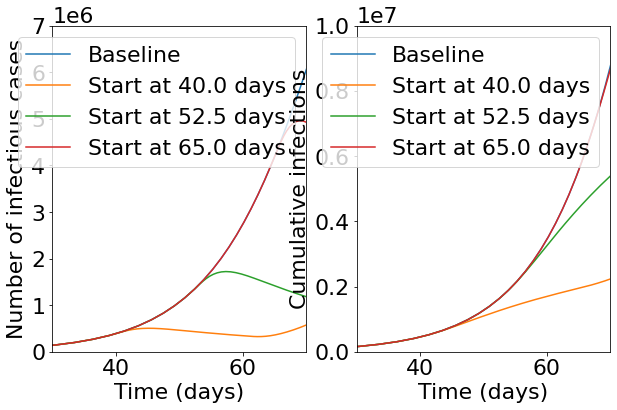

In [13]:
fig, ax = plt.subplots(1, 2, figsize=plot.big_wide_figsize)
for tt in range(0,len(t0ran)):
    ax[0].plot(sol[tt].t,N*(sol[tt].y[3] + sol[tt].y[4]).T, label=mylab(t0ran[tt]))
ax[0].set_xlim([30,70])
ax[0].set_ylim([0,7e6])
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Number of infectious cases')
ax[0].legend()
for tt in range(0,len(t0ran)):
    ax[1].plot(sol[tt].t,N*sol[tt].y[5].T, label=mylab(t0ran[tt]))
ax[1].set_xlim([30,70])
ax[1].set_ylim([0,1e7])
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Cumulative infections')
ax[1].legend()

mlai.write_figure('house-model-zoom.svg', directory='./simulation')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/house-model-zoom.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A zoomed in version of Thomas House’s variation on the SEIR
model for evaluating the effect of early interventions.</i>

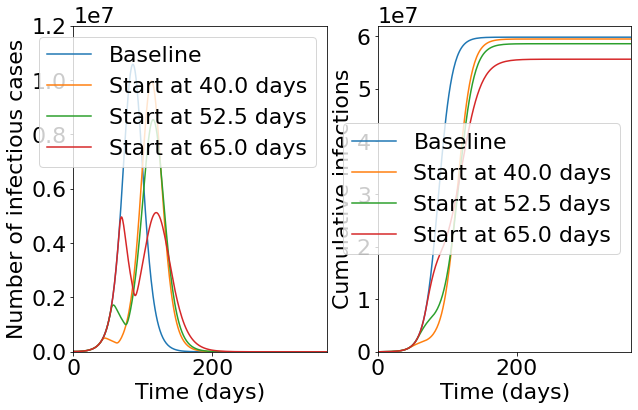

In [14]:
fig, ax = plt.subplots(1, 2, figsize=plot.big_wide_figsize)
for tt in range(0,len(t0ran)):
    ax[0].plot(sol[tt].t,N*(sol[tt].y[3] + sol[tt].y[4]).T, label=mylab(t0ran[tt]))
ax[0].set_xlim([0,tlast])
ax[0].set_ylim([0,1.2e7])
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Number of infectious cases')
ax[0].legend()
for tt in range(0,len(t0ran)):
    ax[1].plot(sol[tt].t,N*sol[tt].y[5].T, label=mylab(t0ran[tt]))
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Cumulative infections')
ax[1].legend()
ax[1].set_xlim([0,tlast])
ax[1].set_ylim([0,6.2e7])

mlai.write_figure('house-model-full.svg', directory='./simulation/')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/house-model-full.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The full progress of the disease in Thomas House’s variation
on the SEIR model for evaluating the effect of early interventions.</i>

In practice, immunity for Covid19 may only last around 6 months. As an
exercise, try to extend Thomas’s model for the case where immunity is
temporary. You’ll need to account for deaths as well in your new model.

Thinking about our Formula 1 example, and the differing levels of
fidelity that might be included in a model, you can now imagine the
challenges of doing large scale theoretical epidemiology. The
compartment model is operating at a particular level of fidelity.
Imagine trying to modify this model for a specific circumstance, like
the way that the University of Cambridge chooses to do lectures. It’s
not appropriate for this level of fidelity. You need to use different
types of models for that decision making. Later, we’ll look at a
simulation that was used to advise the government on the Test Trace
Isolate program that took a different approach (The DELVE Initiative,
2020a).

# Strategies for Simulation

Within any simulation, we can roughly split the variables of interest
into the state variables and the parameters. In the Herd immunity
example, the state variables were the different susceptible, exposed,
infectious and recovered groups. The parameters were the reproduction
number and the expected lengths of infection and the timing of lockdown.
Often parameters are viewed as the inputs to the simulation, the things
we can control. We might want to know how to time lock down to minimize
the number of deaths. This behavior of the simulator is what we may want
to emulate with our Gaussian process model.

So far, we’ve introduced simulation motivated by the physical laws of
the universe. Those laws are sometimes encoded in differential
equations, in which case we can try to solve those systems (like with
Herd Immunity or Navier Stokes). An alternative approach is taken in the
Game of Life. There a turn-based simulation is used, at each turn, we
iterate through the simulation updating the state of the simulation.
This is known as a *discrete event simulation*. In race simulation for
Formula 1 a discrete event simulation is also used. There is another
form of discrete event simulation, often used in chemical models, where
the events don’t take place at regular intervals. Instead, the timing to
the next event is computed, and the simulator advances that amount of
time. For an example of this see [the Gillespie
algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm).

There is a third type of simulation that we’d also like to introduce.
That is simulation within computer software. In particular, the need to
backtest software with ‘what if’ ideas, or to trace errors that may have
occurred in production. This can involve loading up entire code bases
and rerunning them with simulated inputs. This is a third form of
simulation where emulation can also come in useful.

## Backtesting Production Code

In Amazon the team I led looked at examples of simulations and emulation
as varied as Prime Air drones across to the Amazon Supply Chain. In a
purchasing system, the idea is to store stock to balance supply and
demand. The aim is to keep product in stock for quick dispatch while
keeping prices (and therefore costs) low. This idea is at the heart of
Amazon’s focus on customer experience.

## Alexa

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/alexa-system.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/alexa-system.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip0">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Tom Taylor

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/tom-taylor.png" clip-path="url(#clip0)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip1">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Joe Walowski

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/joe-walowski.png" clip-path="url(#clip1)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip2">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Rohit Prasad

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/rohit-prasad.png" clip-path="url(#clip2)"/>

</svg>

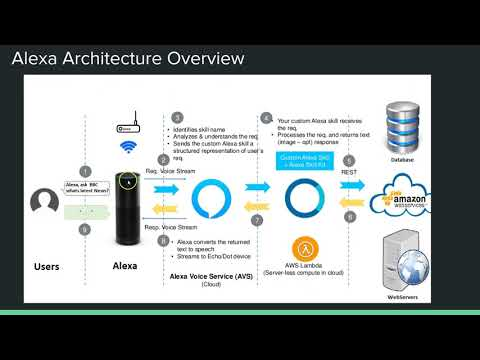

In [15]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('VQVZ2hvNVfo')

Figure: <i>Alexa Architecture overview taken from the Alexa Skills
programme.</i>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip3">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Rohit Prasad

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/rohit-prasad.png" clip-path="url(#clip3)"/>

</svg>

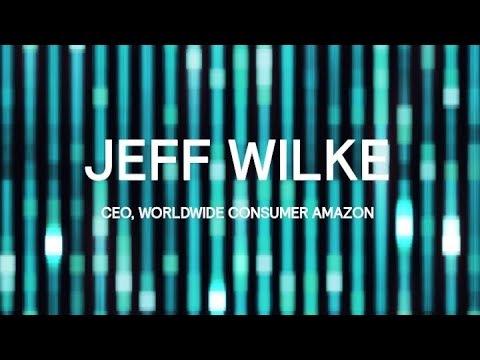

In [16]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('wa8DU-Sui8Q')

Figure: <i>Rohit Prasad talking about Alexa at the Amazon 2019 re:MARS
event.</i>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip4">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Tom Taylor

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/tom-taylor.png" clip-path="url(#clip4)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip5">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Joe Walowski

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/joe-walowski.png" clip-path="url(#clip5)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip6">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Rohit Prasad

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/rohit-prasad.png" clip-path="url(#clip6)"/>

</svg>

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//software/alexa-schematic.svg" class="" width="40%" style="vertical-align:middle;">

Figure: <i>Simple schmeatic of a intelligent agent set of
components.</i>

## Speech to Text

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip7">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Catherine Breslin

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/catherine-breslin.png" clip-path="url(#clip7)"/>

</svg>

## Cloud Service: Knowledge Base

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip8">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

David Hardcastle

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/david-hardcastle.png" clip-path="url(#clip8)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip9">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Arpit Mittal

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/arpit-mittal.png" clip-path="url(#clip9)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip10">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Christos Christodoulopoulos

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/christos-christodoulopoulos.png" clip-path="url(#clip10)"/>

</svg>

## Text to Speech

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip11">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Andrew Breen

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/andrew-breen.png" clip-path="url(#clip11)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip12">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Roberto Barra Chicote

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/roberto-barra-chicote.png" clip-path="url(#clip12)"/>

</svg>

## Prime Air

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/prime-air-system.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/prime-air-system.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

One project where the components of machine learning and the physical
world come together is Amazon’s Prime Air drone delivery system.

Automating the process of moving physical goods through autonomous
vehicles completes the loop between the ‘bits’ and the ‘atoms.’ In other
words, the information and the ‘stuff.’ The idea of the drone is to
complete a component of package delivery, the notion of last mile
movement of goods, but in a fully autonomous way.

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip13">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Gur Kimchi

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/gur-kimchi.png" clip-path="url(#clip13)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip14">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Paul Viola

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/paul-viola.png" clip-path="url(#clip14)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip15">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

David Moro

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/david-moro.png" clip-path="url(#clip15)"/>

</svg>

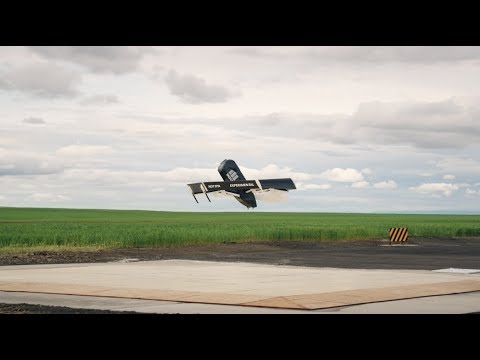

In [17]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('3HJtmx5f1Fc')

Figure: <i>An actual ‘Santa’s sleigh.’ Amazon’s prototype delivery
drone. Machine learning algorithms are used across various systems
including sensing (computer vision for detection of wires, people, dogs
etc) and piloting. The technology is necessarily a combination of old
and new ideas. The transition from vertical to horizontal flight is
vital for efficiency and uses sophisticated machine learning to
achieve.</i>

As Jeff Wilke (who was CEO of Amazon Retail at the time) [announced in
June
2019](https://blog.aboutamazon.com/transportation/a-drone-program-taking-flight)
the technology is ready, but still needs operationalization including
e.g. regulatory approval.

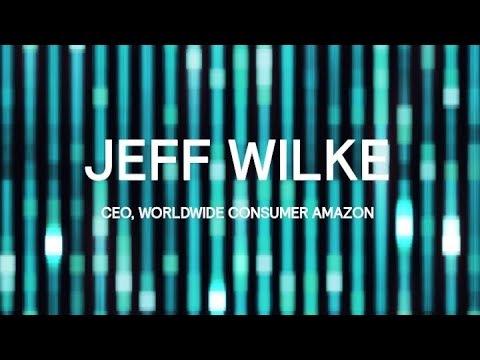

In [18]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('wa8DU-Sui8Q')

Figure: <i>Jeff Wilke (CEO Amazon Consumer) announcing the new drone at
the Amazon 2019 re:MARS event alongside the scale of the Amazon supply
chain.</i>

> When we announced earlier this year that we were evolving our Prime
> two-day shipping offer in the U.S. to a one-day program, the response
> was terrific. But we know customers are always looking for something
> better, more convenient, and there may be times when one-day delivery
> may not be the right choice. Can we deliver packages to customers even
> faster? We think the answer is yes, and one way we’re pursuing that
> goal is by pioneering autonomous drone technology.

> Today at Amazon’s re:MARS Conference (Machine Learning, Automation,
> Robotics and Space) in Las Vegas, we unveiled our latest Prime Air
> drone design. We’ve been hard at work building fully electric drones
> that can fly up to 15 miles and deliver packages under five pounds to
> customers in less than 30 minutes. And, with the help of our
> world-class fulfillment and delivery network, we expect to scale Prime
> Air both quickly and efficiently, delivering packages via drone to
> customers within months.

The 15 miles in less than 30 minutes implies air speed velocities of
around 50 kilometers per hour.

> Our newest drone design includes advances in efficiency, stability
> and, most importantly, in safety. It is also unique, and it advances
> the state of the art. How so? First, it’s a hybrid design. It can do
> vertical takeoffs and landings – like a helicopter. And it’s efficient
> and aerodynamic—like an airplane. It also easily transitions between
> these two modes—from vertical-mode to airplane mode, and back to
> vertical mode.

> It’s fully shrouded for safety. The shrouds are also the wings, which
> makes it efficient in flight.

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//ai/amazon-prime-air-remars-june-2019.jpg" style="width:80%">

Figure: <i>Picture of the drone from Amazon Re-MARS event in 2019.</i>

> Our drones need to be able to identify static and moving objects
> coming from any direction. We employ diverse sensors and advanced
> algorithms, such as multi-view stereo vision, to detect static objects
> like a chimney. To detect moving objects, like a paraglider or
> helicopter, we use proprietary computer-vision and machine learning
> algorithms.

> A customer’s yard may have clotheslines, telephone wires, or
> electrical wires. Wire detection is one of the hardest challenges for
> low-altitude flights. Through the use of computer-vision techniques
> we’ve invented, our drones can recognize and avoid wires as they
> descend into, and ascend out of, a customer’s yard.

## Supply Chain Optimization

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/supply-chain-system.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/supply-chain-system.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip16">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Llew Mason

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/llew-mason.png" clip-path="url(#clip16)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip17">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Devesh Mishra

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/devesh-mishra.png" clip-path="url(#clip17)"/>

</svg>

Supply chain is the process of matching between the supply of the
product and demand for the product. This matching process is done
through the deployment of resources: places to store the products, ways
and means of transporting the product and even the ability to transform
products from one form to another (e.g. transforming paper into books
through printing).

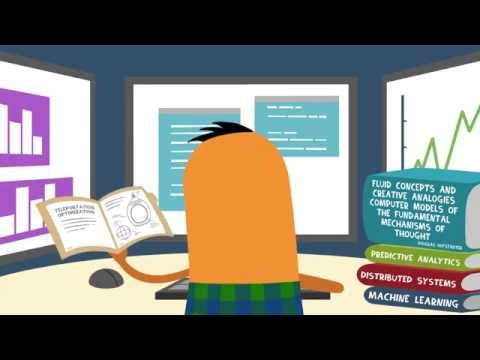

In [19]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('ncwsr1Of6Cw')

Figure: <i>Promotional video for the Amazon supply chain optimization
team.</i>

Arugably the Amazon supply chain is the largest automated decision
making system in the world in terms of the amount of money spent and the
quantity of product moved through automated decision making.

## Supply Chain Optimization

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip18">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Llew Mason

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/llew-mason.png" clip-path="url(#clip18)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip19">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Devesh Mishra

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/devesh-mishra.png" clip-path="url(#clip19)"/>

</svg>

At the heart of an automated supply chain is the buying system, which
determines the optimal stock level for products and makes purchases
based on the difference between that stock level and the current stock
level.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//software/buying-schematic.svg" class="" width="40%" style="vertical-align:middle;">

Figure: <i>A schematic of a typical buying system for supply chain.</i>

To make these decisions predictive models (often machine learning or
statistical models) have to be moved. For example, the demand for a
particular product needs to be forecast.

## Forecasting

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip20">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Jenny Freshwater

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/jenny-freshwater.png" clip-path="url(#clip20)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip21">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Ping Xu

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/ping-xu.png" clip-path="url(#clip21)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip22">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Dean Foster

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/dean-foster.png" clip-path="url(#clip22)"/>

</svg>

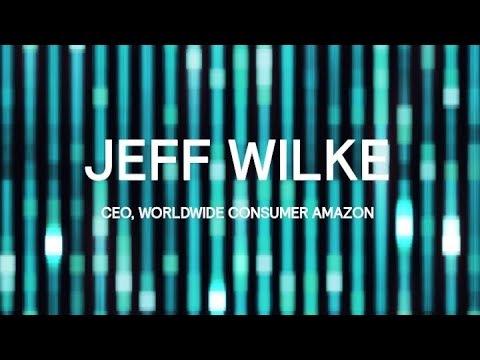

In [20]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('wa8DU-Sui8Q')

Figure: <i>Jenny Freshwater speaking at the Amazon re:MARS event in June
2019.</i>

The process of forecasting is described by Jenny Freshwater (at the time
Director for Forecasting within Amazon’s Supply Chain Optimization team
in the video in Figure .

For each product in the Amazon catalogue, the demand is forecast across
the a given future period.

## Inventory and Buying

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip23">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Deepak Bhatia

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/deepak-bhatia.png" clip-path="url(#clip23)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip24">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Piyush Saraogi

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/piyush-saraogi.png" clip-path="url(#clip24)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip25">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Raman Iyer

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/raman-iyer.jpg" clip-path="url(#clip25)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip26">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Salal Humair

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/salal-humair.png" clip-path="url(#clip26)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip27">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Narayan Venkatasubramanyan

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/narayan-venkatasubramanyan.png" clip-path="url(#clip27)"/>

</svg>

Forecast information is combined with predictions around lead times from
suppliers, understanding of the network’s capacity (in terms of how much
space is available in which fulfillment centers), the cost of storing
and transporting products and the “value” for the consumer in finding
the product is in stock. These models are typically operational research
models (such as the “newsvendor problem” combined with machine learning
and/or statistical forecasts.

## Buying System

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/buying-system.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/buying-system.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

An example of a complex decision-making system might be an automated
buying system. In such a system, the idea is to match demand for
products to supply of products.

The matching of demand and supply is a repetitive theme for decision
making systems. Not only does it occur in automated buying, but also in
the allocation of drivers to riders in a ride sharing system. Or in the
allocation of compute resource to users in a cloud system.

The components of any of these systems include predictions of the demand
for the product, the drivers, or the compute. Predictions of the supply.
Decisions are then made for how much material to keep in stock, or how
many drivers to have on the road, or how much computer capacity to have
in your data centers. These decisions have cost implications. The
optimal amount of product will depend on the cost of making it
available. For a buying system this is the storage costs.

Decisions are made based on the supply and demand to make new orders, to
encourage more drivers to come into the system or to build new data
centers or rent more computational power.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//software/buying-schematic.svg" class="" width="40%" style="vertical-align:middle;">

Figure: <i>The components of a putative automated buying system</i>

## Monolithic System

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/aws-soa.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_ai/includes/aws-soa.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

The classical approach to building these systems was a ‘monolithic
system.’ Built in a similar way to the successful applications software
such as Excel or Word, or large operating systems, a single code base
was constructed. The complexity of such code bases run to many lines.

In practice, shared dynamically linked libraries may be used for aspects
such as user interface, or networking, but the software often has many
millions of lines of code. For example, the Microsoft Office suite is
said to contain over 30 million lines of code.

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip28">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Charlie Bell

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/charlie-bell.png" clip-path="url(#clip28)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip29">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Peter Vosshall

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/peter-vosshall.png" clip-path="url(#clip29)"/>

</svg>

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//ai/ml-system-monolith-purchasing.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>A potential path of models in a machine learning system.</i>

Such software is not only difficult to develop, but also to scale when
computation demands increase. Amazon’s original website software (called
Obidos) was a [monolithic
design](https://en.wikipedia.org/wiki/Obidos_(software)) but by the
early noughties it was becoming difficult to sustain and maintain. The
software was phased out in 2006 to be replaced by a modularized software
known as a ‘service-oriented architecture.’

## Service Oriented Architecture

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip30">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Charlie Bell

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/charlie-bell.png" clip-path="url(#clip30)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip31">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Peter Vosshall

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/peter-vosshall.png" clip-path="url(#clip31)"/>

</svg>

In Service Oriented Architecture, or “Software as a Service” the idea is
that code bases are modularized and communicate with one another using
network requests. A standard approach is to use a [REST
API](https://en.wikipedia.org/wiki/Representational_state_transfer). So,
rather than a single monolithic code base, the code is developed with
individual services that handle the different requests.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//ai/ml-system-downstream-purchasing000.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>A potential path of models in a machine learning system.</i>

Modern software development uses an approach known as *service-oriented
architecture* to build highly complex systems. Such systems have similar
emergent properties to Conway’s “Game of Life.” Understanding these
emergent properties is vitally important when diagnosing problems in the
system.

In the context of machine learning and complex systems, Jonathan
Zittrain has coined the term [“Intellectual
Debt”](https://medium.com/berkman-klein-center/from-technical-debt-to-intellectual-debt-in-ai-e05ac56a502c)
to describe the challenge of understanding what you’ve created.

This is the landscape we now find ourselves in with regard to software
development. In practice, each of these services is often ‘owned’ and
maintained by an individual team. The team is judged by the quality of
their service provision. They work to detailed specifications on what
their service should output, what its availability should be and other
objectives like speed of response. This allows for conditional
independence between teams and for faster development.

Clearly Conway’s Game of Life exhibits an enormous amount of
intellectual debt, indeed that was the idea. Build something simple that
exhibits great complexity. That’s what makes it so popular. But in
deployed system software, intellectual debt is a major headache and
emulation presents one way of dealing with it.

Unfortunately, it also makes sophisticated software systems a breeding
ground for intellectual debt. Particularly when they contain components
which are themselves ML components. Dealing with this challenge is a
major objective of my Senior AI Fellowship at the Alan Turing Institute.
You can see me talking about the problems [at this recent seminar given
virtually in
Manchester](http://inverseprobability.com/talks/notes/deploying-machine-learning-systems-intellectual-debt-and-auto-ai.html).

[Simpy](https://simpy.readthedocs.io/en/latest/examples/gas_station_refuel.html)

-   News Vendor Problem

-   Trolley & Pendulum

-   Mountain Car

-   Hodgkin Huxley

-   Formula One Race

-   Plane/F1 Car/Drone

-   [Fluid Dynamics](https://github.com/barbagroup/CFDPython)
    Discretisation of PDEs

-   [Stress in a connecting
    rod](https://solidspy.readthedocs.io/en/latest/readme.html)
    Discretisation of PDEs

-   [Network simulation](https://github.com/mkalewski/sim2net) Discrete
    Event

-   Reaction Rates:

## Simulation System

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/simulation-system.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/simulation-system.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

An example of a complex decision-making system might be a climate model,
in such a system there are separate models for the atmosphere, the ocean
and the land.

The components of these systems include flowing of currents, chemical
interactions in the upper atmosphere, evaporation of water etc..

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/carbon_cycle.jpg" style="width:60%">

Figure: <i>Representation of the Carbon Cycle from the US National
Oceanic and Atmospheric Administration. While everything is
interconnected in the system, we can decompose into separate models for
atmosphere, ocean, land.</i>

The influence of human activity also needs to be incorporated and
modelled so we can make judgments about how to mitigate the effects of
global warming.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/simulation-schematic.svg" class="" width="40%" style="vertical-align:middle;">

Figure: <i>The components of a simulation system for climate
modelling.</i>

## Monolithic System

The classical approach to building these systems was a ‘monolithic
system.’ Built in a similar way to the successful applications software
such as Excel or Word, or large operating systems, a single code base
was constructed. The complexity of such code bases run to many lines.

In practice, shared dynamically linked libraries may be used for aspects
such as user interface, or networking, but the software often has many
millions of lines of code. For example, the Microsoft Office suite is
said to contain over 30 million lines of code.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/ml-system-monolith-simulation.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>A potential path of models in a machine learning system.</i>

## Service Oriented Architecture

Such software is not only difficult to develop, but also to scale when
computation demands increase. For example, Amazon’s original website
software (called Obidos) was a [monolithic
design](https://en.wikipedia.org/wiki/Obidos_(software)) but by the
early noughties it was becoming difficult to sustain and maintain. The
software was phased out in 2006 to be replaced by a modularized software
known as a ‘service-oriented architecture.’

In Service Oriented Architecture, or “Software as a Service” the idea is
that code bases are modularized and communicate with one another using
network requests. A standard approach is to use a [REST
API](https://en.wikipedia.org/wiki/Representational_state_transfer). So,
rather than a single monolithic code base, the code is developed with
individual services that handle the different requests.

The simulation software is turned inside out to expose the individual
components to the operator.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/ml-system-downstream-simulation000.svg" class="" width="60%" style="vertical-align:middle;">

Figure: <i>A potential path of models in a machine learning system.</i>

This is the landscape we now find ourselves in for software development.
In practice, each of these services is often ‘owned’ and maintained by
an individual team. The team is judged by the quality of their service
provision. They work to detailed specifications on what their service
should output, what its availability should be and other objectives like
speed of response. This allows for conditional independence between
teams and for faster development.

One question is to what extent is the same approach possible/desirable
for scientific models? The components we listed above are already
separated and often run independently. But those components themselves
are made up of other sub-components that could also be exposed in a
similar manner to software-as-a-service, giving us the notion of
“simulation as a service.”

One thing about working in an industrial environment, is the way that
short-term thinking actions become important. For example, in Formula
One, the teams are working on a two-week cycle to digest information
from the previous week’s race and incorporate updates to the car or
their strategy.

However, businesses must also think about more medium-term horizons. For
example, in Formula 1 you need to worry about next year’s car. So, while
you’re working on updating this year’s car, you also need to think about
what will happen for next year and prioritize these conflicting needs
appropriately.

In the Amazon supply chain, there are equivalent demands. If we accept
that an artificial intelligence is just an automated decision-making
system. And if we measure in terms of money automatically spent, or
goods automatically moved, then Amazon’s buying system is perhaps the
world’s largest AI.

Those decisions are being made on short time schedules; purchases are
made by the system on weekly cycles. But just as in Formula 1, there is
also a need to think about what needs to be done next month, next
quarter and next year. Planning meetings are held not only on a weekly
basis (known as weekly business reviews), but monthly, quarterly, and
then yearly meetings for planning spends and investments.

Amazon is known for being longer term thinking than many companies, and
a lot of this is coming from the CEO. One quote from Jeff Bezos that
stuck with me was the following.

> “I very frequently get the question: ‘What’s going to change in the
> next 10 years?’ And that is a very interesting question; it’s a very
> common one. I almost never get the question: ‘What’s not going to
> change in the next 10 years?’ And I submit to you that that second
> question is actually the more important of the two – because you can
> build a business strategy around the things that are stable in time. …
> \[I\]n our retail business, we know that customers want low prices,
> and I know that’s going to be true 10 years from now. They want fast
> delivery; they want vast selection. It’s impossible to imagine a
> future 10 years from now where a customer comes up and says, ‘Jeff I
> love Amazon; I just wish the prices were a little higher,’ \[or\] ‘I
> love Amazon; I just wish you’d deliver a little more slowly.’
> Impossible. And so the effort we put into those things, spinning those
> things up, we know the energy we put into it today will still be
> paying off dividends for our customers 10 years from now. When you
> have something that you know is true, even over the long term, you can
> afford to put a lot of energy into it.”

This quote is incredibly important for long term thinking. Indeed, it’s
a failure of many of our simulations that they focus on what is going to
happen, not what will not happen. In Amazon, this meant that there was
constant focus on these three areas, keeping costs low, making delivery
fast and improving selection. For example, shortly before I left Amazon
moved its entire US network from two-day delivery to one-day delivery.
This involves changing the way the entire buying system operates. Or,
more recently, the company has had to radically change the portfolio of
products it buys in the face of Covid19.

<!--These challenges are not just there for Amazon and Formula 1. In Sheffield, we worked closely with a Chesterfield based company called Fusion Group. They make joints that fuse PTFE pipes together. These pipes are used for transporting both water and gas. Their founder, Eric Bridgstock, was an engineer who introduced PTFE piping to the UK when working for DuPont. Eric set up Fusion group to manufacture the fusion fittings. Because PTFE pipes carry water or gas at high pressure, when these fittings fail significant damage can occur. When these fittings were originally installed in the early 1980s, the job was done by a specialist, but nowadays the pipe weld is compelted by the same team that digs the hole. While costs have come down, the number of PTFE weld failures went up. Eric's company focussed on new systems for auto-->

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//ml/experiment-analyze-design.svg" class="" width="50%" style="vertical-align:middle;">

Figure: <i>Experiment, analyze and design is a flywheel of knowledge
that is the dual of the model, data and compute. By running through this
spiral, we refine our hypothesis/model and develop new experiments which
can be analyzed to further refine our hypothesis.</i>

From the perspective of the team that we had in the supply chain, we
looked at what we most needed to focus on. Amazon moves very quickly,
but we could also take a leaf out of Jeff’s book, and instead of
worrying about what was going to change, remember what wasn’t going to
change.

> We don’t know what science we’ll want to do in five years’ time, but
> we won’t want slower experiments, we won’t want more expensive
> experiments and we won’t want a narrower selection of experiments.

As a result, our focus was on how to speed up the process of
experiments, increase the diversity of experiments that we can do, and
keep the experiments price as low as possible.

The faster the innovation flywheel can be iterated, then the quicker we
can ask about different parts of the supply chain, and the better we can
tailor systems to answering those questions.

We need faster, cheaper and more diverse experiments which implies we
need better ecosystems for experimentation. This has led us to focus on
the software frameworks we’re using to develop machine learning systems
including data oriented architectures (Borchert (2020);Lawrence
(2019);Vorhemus and Schikuta (2017);Joshi (2007)), data maturity
assessments (Lawrence et al. (2020)) and data readiness levels (See this
blog post on [Data Readiness
Levels](http://inverseprobability.com/2017/01/12/data-readiness-levels).
and Lawrence (2017);The DELVE Initiative (2020b))

## Packing Problems

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/packing-problems.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_simulation/includes/packing-problems.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/friedman/s9.gif" style="width:50%">

Figure: <i>Packing 9 squares into a single square. This example is
trivially solved. Credit <https://erich-friedman.github.io/packing/></i>

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/friedman/s17.gif" style="width:50%">

Figure: <i>Packing 17 squares into a single square. The optimal solution
is sometimes hard to find. Here the side length of the smallest square
that holds 17 similarly shaped squares is at least 4.675 times the
smaller square. This solution found by John Bidwell in 1997. Credit
<https://erich-friedman.github.io/packing/></i>

Another example of a problem where the “physics” is understood because
it’s really mathematics, is packing problems. Here the mathematics is
just geometry, but still we need some form of compute to solve these
problems. [Erich Friedman’s
website](https://erich-friedman.github.io/packing/) contains a host of
these problems, only some of which are analytically tractable.

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/friedman/s10.gif" style="width:50%">

Figure: <i>Packing 10 squares into a single square. This example is
proven by Walter Stromquist (Stromquist, 1984). Here
$s=3+\frac{1}{\sqrt{2}}$. Credit
<https://erich-friedman.github.io/packing/></i>

## Modelling with a Function

What if the question of interest was quite simple, for example in the
packing problem, we just wanted to know the minimum side length.
Sometimes, regardless of the complexity of the problem, there can be a
pattern to the answer that is emergent due to regularities in the
underlying problem.

## Erich Friedman Packing Data

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/erich-friedman-packing-data.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_datasets/includes/erich-friedman-packing-data.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

In [21]:
%pip install pods

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
import pods

 /Users/neil/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning:The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.


In [23]:
data = pods.datasets.erich_friedman_packing_data()
x = data['X']
y = data['Y']

In [24]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [25]:
import pods
from matplotlib import pyplot as plt

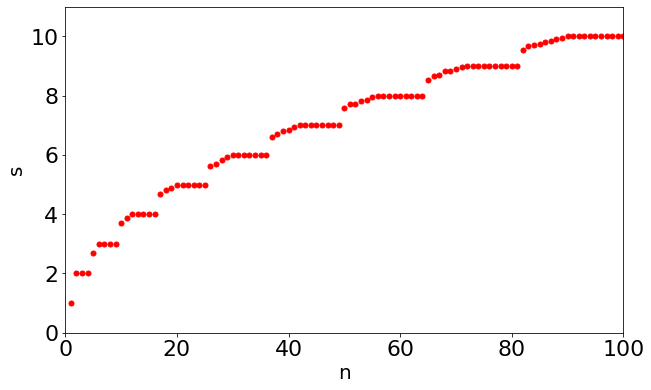

In [26]:
xlim = (0,100)
ylim = (0, 11)

fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
_ = ax.plot(x, y, 'r.',markersize=10)
ax.set_xlabel('n', fontsize=20)
ax.set_ylabel('s', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

mlai.write_figure(filename='squares-in-squares.svg', 
                  directory='./datasets')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//datasets/squares-in-squares.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Plot of minimum side length known as a function of number of
squares inside.</i>

In [27]:
%pip install gpy

Note: you may need to restart the kernel to use updated packages.


## Gaussian Process Fit

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/erich-friedman-packing-gp.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/erich-friedman-packing-gp.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Our first objective will be to perform a Gaussian process fit to the
data, we’ll do this using the [GPy
software](https://github.com/SheffieldML/GPy).

In [28]:
import GPy

In [29]:
m_full = GPy.models.GPRegression(x,y)
_ = m_full.optimize() # Optimize parameters of covariance function

The first command sets up the model, then `m_full.optimize()` optimizes
the parameters of the covariance function and the noise level of the
model. Once the fit is complete, we’ll try creating some test points,
and computing the output of the GP model in terms of the mean and
standard deviation of the posterior functions between 1870 and 2030. We
plot the mean function and the standard deviation at 200 locations. We
can obtain the predictions using `y_mean, y_var = m_full.predict(xt)`

In [30]:
xt = np.linspace(0,100,400)[:,np.newaxis]
yt_mean, yt_var = m_full.predict(xt)
yt_sd=np.sqrt(yt_var)

Now we plot the results using the helper function in `mlai.plot`.

In [31]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

 /Users/neil/opt/anaconda3/lib/python3.8/site-packages/mlai-0.1.2-py3.8.egg/mlai/mlai.py:43: MatplotlibDeprecationWarning:savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


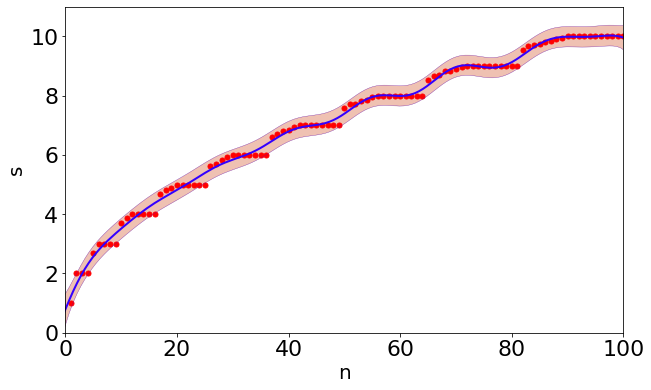

In [32]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.model_output(m_full, ax=ax,  xlabel="n", ylabel="s", fontsize=20, portion=0.2)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
mlai.write_figure(figure=fig,
                  filename="erich-friedman-packing-gp.svg", 
                  directory = "./gp",
                  transparent=True, frameon=True)

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/erich-friedman-packing-gp.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Gaussian process fit to the Erich Friedman Packing data.</i>

## Statistical Emulation

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/emulation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/emulation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//simulation/unified-model-systems.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The UK Met office runs a shared code base for its simulations
of climate and the weather. This plot shows the different spatial and
temporal scales used.</i>

In many real-world systems, decisions are made through simulating the
environment. Simulations may operate at different granularities. For
example, simulations are used in weather forecasts and climate
forecasts. Interestingly, the UK Met office uses the same code for both,
it has a [“Unified Model”
approach](https://www.metoffice.gov.uk/research/approach/modelling-systems/unified-model/index),
but they operate climate simulations at greater spatial and temporal
resolutions.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//uq/statistical-emulation000.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Real world systems consist of simulators that capture our
domain knowledge about how our systems operate. Different simulators run
at different speeds and granularities.</i>

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//uq/statistical-emulation001.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A statistical emulator is a system that reconstructs the
simulation with a statistical model.</i>

A statistical emulator is a data-driven model that learns about the
underlying simulation. Importantly, learns with uncertainty, so it
‘knows what it doesn’t know.’ In practice, we can call the emulator in
place of the simulator. If the emulator ‘doesn’t know,’ it can call the
simulator for the answer.

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//uq/statistical-emulation004.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A statistical emulator is a system that reconstructs the
simulation with a statistical model. As well as reconstructing the
simulation, a statistical emulator can be used to correlate with the
real world.</i>

As well as reconstructing an individual simulator, the emulator can
calibrate the simulation to the real world, by monitoring differences
between the simulator and real data. This allows the emulator to
characterize where the simulation can be relied on, i.e., we can
validate the simulator.

Similarly, the emulator can adjudicate between simulations. This is
known as *multi-fidelity emulation*. The emulator characterizes which
emulations perform well where.

If all this modelling is done with judicious handling of the
uncertainty, the *computational doubt*, then the emulator can assist in
deciding what experiment should be run next to aid a decision: should we
run a simulator, in which case which one, or should we attempt to
acquire data from a real-world intervention.

## GPy: A Gaussian Process Framework in Python

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/gpy-software.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_software/includes/gpy-software.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Gaussian processes are a flexible tool for non-parametric analysis with
uncertainty. The GPy software was started in Sheffield to provide a easy
to use interface to GPs. One which allowed the user to focus on the
modelling rather than the mathematics.

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/gpy.png" style="width:70%">

Figure: <i>GPy is a BSD licensed software code base for implementing
Gaussian process models in Python. It is designed for teaching and
modelling. We welcome contributions which can be made through the GitHub
repository <https://github.com/SheffieldML/GPy></i>

GPy is a BSD licensed software code base for implementing Gaussian
process models in python. This allows GPs to be combined with a wide
variety of software libraries.

The software itself is available on
[GitHub](https://github.com/SheffieldML/GPy) and the team welcomes
contributions.

The aim for GPy is to be a probabilistic-style programming language,
i.e., you specify the model rather than the algorithm. As well as a
large range of covariance functions the software allows for non-Gaussian
likelihoods, multivariate outputs, dimensionality reduction and
approximations for larger data sets.

The documentation for GPy can be found
[here](https://gpy.readthedocs.io/en/latest/).

## GPy Tutorial

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/gpy-tutorial.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/gpy-tutorial.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip32">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

James Hensman

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/james-hensman.png" clip-path="url(#clip32)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip33">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Nicolas Durrande

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/nicolas-durrande2.jpg" clip-path="url(#clip33)"/>

</svg>

This GPy tutorial is based on material we share in the Gaussian process
summer school for teaching these models <https://gpss.cc>. It contains
material from various members and former members of the Sheffield
machine learning group, but particular mention should be made of
[Nicolas
Durrande](https://sites.google.com/site/nicolasdurrandehomepage/) and
[James Hensman](https://jameshensman.github.io/), see
<http://gpss.cc/gpss17/labs/GPSS_Lab1_2017.ipynb>.

In [33]:
import numpy as np
import GPy

In [34]:
from matplotlib import pyplot as plt

To give a feel for the software we’ll start by creating an exponentiated
quadratic covariance function, $$
k(\mathbf{ x}, \mathbf{ x}^\prime) = \alpha \exp\left(-\frac{\left\Vert \mathbf{ x}- \mathbf{ x}^\prime \right\Vert_2^2}{2\ell^2}\right),
$$ where the length scale is $\ell$ and the variance is $\alpha$.

To set this up in GPy we create a kernel in the following manner.

In [35]:
input_dim=1
alpha = 1.0
lengthscale = 2.0
kern = GPy.kern.RBF(input_dim=input_dim, variance=alpha, lengthscale=lengthscale)

That builds a kernel object for us. The kernel can be displayed.

In [36]:
display(kern)

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,2.0,+ve,


Or because it’s one dimensional, you can also plot the kernel as a
function of its inputs (while the other is fixed).

In [37]:
import mlai
import mlai.plot as plot

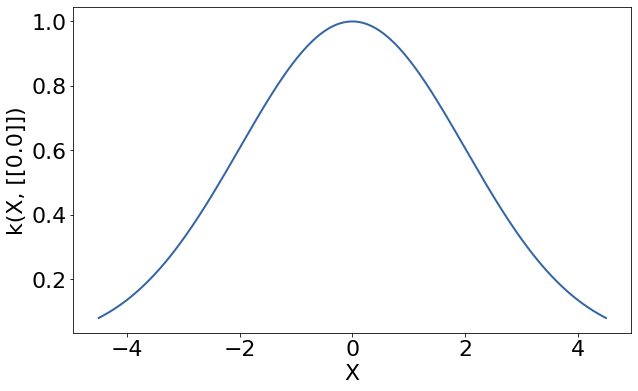

In [38]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
kern.plot(ax=ax)
mlai.write_figure('gpy-eq-covariance.svg', directory='./kern')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//kern/gpy-eq-covariance.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The exponentiated quadratic covariance function as plotted by
the `GPy.kern.plot` command.</i>

You can set the length scale of the covariance to different values and
plot the result.

In [39]:
kern = GPy.kern.RBF(input_dim=input_dim)     # By default, the parameters are set to 1.
lengthscales = np.asarray([0.2,0.5,1.,2.,4.])

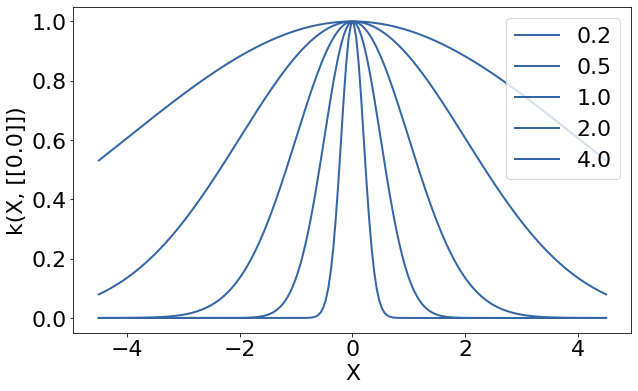

In [40]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

for lengthscale in lengthscales:
    kern.lengthscale=lengthscale
    kern.plot(ax=ax)

ax.legend(lengthscales)
mlai.write_figure('gpy-eq-covariance-lengthscales.svg', directory='./kern')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//kern/gpy-eq-covariance-lengthscales.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>The exponentiated quadratic covariance function plotted for
different length scales by `GPy.kern.plot` command.</i>

## Covariance Functions in GPy

Many covariance functions are already implemented in GPy. Instead of
rbf, try constructing and plotting the following covariance functions:
`exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`,
`rbfcos`, `periodic_Matern32`, etc. Some of these covariance functions,
such as `rbfcos`, are not parametrized by a variance and a length scale.
Further, not all kernels are stationary (i.e., they can’t all be written
as
$k(\mathbf{ x}, \mathbf{ x}^\prime) = f(\mathbf{ x}-\mathbf{ x}^\prime)$,
see for example the Brownian covariance function). So for plotting it
may be interesting to change the value of the fixed input.

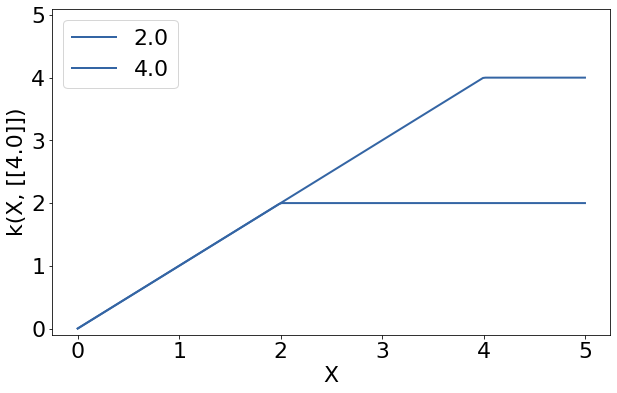

In [41]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

brownian_kern = GPy.kern.Brownian(input_dim=1)
inputs = np.array([2., 4.])
for x in inputs:
    brownian_kern.plot(x,plot_limits=[0,5], ax=ax)
ax.legend(inputs)
ax.set_ylim(-0.1,5.1)

mlai.write_figure('gpy-brownian-covariance-lengthscales.svg', directory='./kern')

## Combining Covariance Functions in GPy

In GPy you can easily combine covariance functions you have created
using the sum and product operators, `+` and `*`. So, for example, if we
wish to combine an exponentiated quadratic covariance with a Matern 5/2
then we can write

In [42]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 + kern2
display(kern)

sum.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,2.0,+ve,
Mat52.variance,2.0,+ve,
Mat52.lengthscale,4.0,+ve,


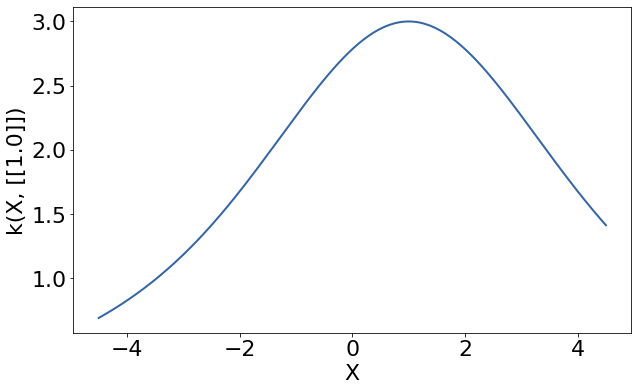

In [43]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

kern.plot(ax=ax)

mlai.write_figure('gpy-eq-plus-matern52-covariance.svg', directory='./kern')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//kern/gpy-eq-plus-matern52-covariance.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A combination of the exponentiated quadratic covariance plus
the Matern $5/2$ covariance.</i>

Or if we wanted to multiply them, we can write

In [44]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern52(1, variance=2., lengthscale=4.)
kern = kern1 * kern2
display(kern)

mul.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,2.0,+ve,
Mat52.variance,2.0,+ve,
Mat52.lengthscale,4.0,+ve,


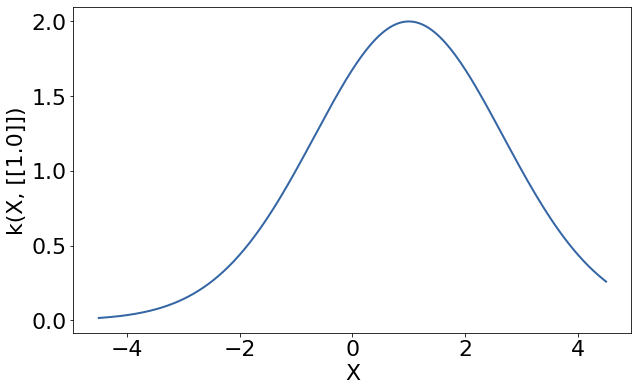

In [45]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

kern.plot(ax=ax)

mlai.write_figure('gpy-eq-times-matern52-covariance.svg', directory='./kern')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//kern/gpy-eq-times-matern52-covariance.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A combination of the exponentiated quadratic covariance
multiplied by the Matern $5/2$ covariance.</i>

You can learn about how to implement [new kernel objects in GPy
here](https://gpy.readthedocs.io/en/latest/tuto_creating_new_kernels.html).

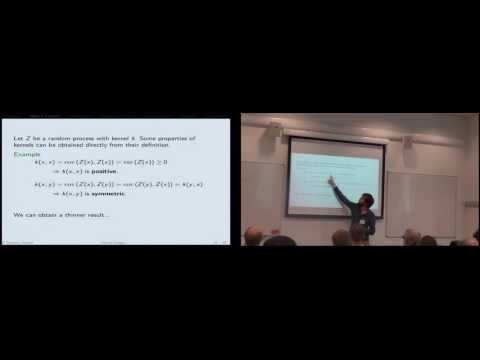

In [46]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('-sY8zW3Om1Y')

Figure: <i>Designing the covariance function for your Gaussian process
is a key place in which you introduce your understanding of the data
problem. To learn more about the design of covariance functions, see
this talk from Nicolas Durrande at GPSS in 2016.</i>

## A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a
GP regression model with GPy. We will generate data from the function $$
f( x) = − \cos(\pi x) + \sin(4\pi x)
$$ over the domain $[0, 1]$, adding some noise to gives $$
y(x) = f(x) + \epsilon,
$$ with the noise being Gaussian distributed,
$\epsilon\sim \mathcal{N}\left(0,0.01\right)$.

In [47]:
X = np.linspace(0.05,0.95,10)[:,np.newaxis]
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + np.random.normal(loc=0.0, scale=0.1, size=(10,1))

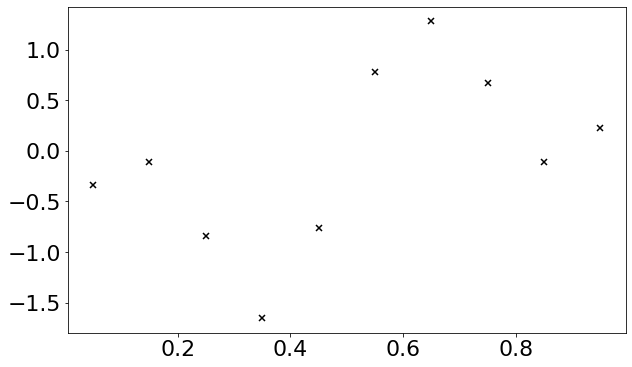

In [48]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
ax.plot(X,Y,'kx',mew=1.5, linewidth=2)

mlai.write_figure('noisy-sine.svg', directory='./gp')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/noisy-sine.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>Data from the noisy sine wave for fitting with a GPy
model.</i>

A GP regression model based on an exponentiated quadratic covariance
function can be defined by first defining a covariance function.

In [49]:
kern = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

And then combining it with the data to form a Gaussian process model.

In [50]:
model = GPy.models.GPRegression(X,Y,kern)

Just as for the covariance function object, we can find out about the
model using the command `display(model)`.

In [51]:
display(model)

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


Note that by default the model includes some observation noise with
variance 1. We can see the posterior mean prediction and visualize the
marginal posterior variances using `model.plot()`.

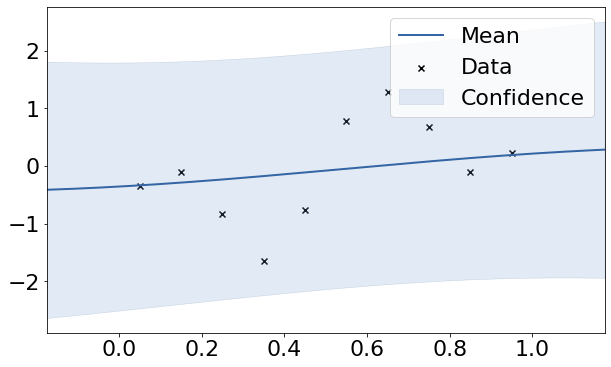

In [52]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
model.plot(ax=ax)

mlai.write_figure('noisy-sine-gp-fit.svg', directory='./gp')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/noisy-sine-gp-fit.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A Gaussian process fit to the noisy sine data. Here the
parameters of the process and the covariance function haven’t yet been
optimized.</i>

You can also look directly at the predictions for the model using.

In [53]:
Xstar = np.linspace(0, 10, 100)[:, np.newaxis]
Ystar, Vstar = model.predict(Xstar)

Which gives you the mean (`Ystar`), the variance (`Vstar`) at the
locations given by `Xstar`.

## Covariance Function Parameter Estimation

As we have seen during the lectures, the parameters values can be
estimated by maximizing the likelihood of the observations. Since we
don’t want any of the variances to become negative during the
optimization, we can constrain all parameters to be positive before
running the optimization.

In [54]:
model.constrain_positive()

The warnings are because the parameters are already constrained by
default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `model.optimize()` method. Here
we switch messages on, which allows us to see the progression of the
optimization.

In [55]:
model.optimize(messages=True)

By default, the optimization is using a limited memory BFGS optimizer
(Byrd et al., 1995).

Once again, we can display the model, now to see how the parameters have
changed.

In [56]:
display(model)

GP_regression.,value,constraints,priors
rbf.variance,1.0595881895010528,+ve,
rbf.lengthscale,0.14410260161071511,+ve,
Gaussian_noise.variance,3.0471503705422464e-11,+ve,


The length scale is much smaller, as well as the noise level. The
variance of the exponentiated quadratic has also reduced.

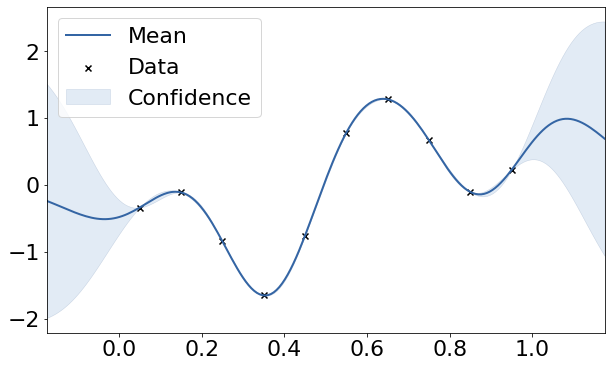

In [57]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
model.plot(ax=ax)

mlai.write_figure('noisy-sine-gp-optimized-fit.svg', directory='./gp')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/noisy-sine-gp-optimized-fit.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A Gaussian process fit to the noisy sine data with parameters
optimized.</i>

## GPy and Emulation

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/gpy-emulation.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_gp/includes/gpy-emulation.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

Let $\mathbf{ x}$ be a random variable defined over the real numbers,
$\Re$, and $f(\cdot)$ be a function mapping between the real numbers
$\Re \rightarrow \Re$.

The problem of *uncertainty propagation* is the study of the
distribution of the random variable $f(\mathbf{ x})$.

We’re going to address this problem using emulation and GPy. We will see
in this section the advantage of using a model when only a few
observations of $f$ are available.

Firstly, we’ll make use of a test function known as the Branin test
function. $$
f(\mathbf{ x}) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t \cos(x_1)) + s
$$ where we are setting $a=1$, $b=5.1/(4\pi^2)$, $c=5/\pi$, $r=6$,
$s=10$ and $t=1/(8\pi)$.

In [58]:
import numpy as np

In [59]:
def branin(X):
    y = ((X[:,1]-5.1/(4*np.pi**2)*X[:,0]**2+5*X[:,0]/np.pi-6)**2 
        + 10*(1-1/(8*np.pi))*np.cos(X[:,0])+10)
    return(y)

We’ll define a grid of twenty-five observations over \[−5, 10\] × \[0,
15\] and a set of 25 observations.

In [60]:
# Training set defined as a 5*5 grid:
xg1 = np.linspace(-5,10,5)
xg2 = np.linspace(0,15,5)
X = np.zeros((xg1.size * xg2.size,2))
for i,x1 in enumerate(xg1):
    for j,x2 in enumerate(xg2):
        X[i+xg1.size*j,:] = [x1,x2]

Y = branin(X)[:,np.newaxis]

The task here will be to consider the distribution of $f(U)$, where $U$
is a random variable with uniform distribution over the input space of
$f$. We focus on the computaiton of two quantities, the expectation of
$f(U)$, $\left\langle f(U)\right\rangle$, and the probability that the
value is greater than 200.

## Computation of $\left\langle f(U)\right\rangle$

The expectation of $f(U )$ is given by
$\int_\mathbf{ x}f( \mathbf{ x})\text{d}\mathbf{ x}$. A basic approach
to approximate this integral is to compute the mean of the 25
observations: `np.mean(Y)`. Since the points are distributed on a grid,
this can be seen as the approximation of the integral by a rough Riemann
sum.

In [61]:
print('Estimate of the expectation is given by: {mean}'.format(mean=Y.mean()))

Estimate of the expectation is given by: 73.5128736264599


The result can be compared with the actual mean of the Branin function
which is 54.31.

Alternatively, we can fit a GP model and compute the integral of the
best predictor by Monte Carlo sampling.

Firstly, we create the covariance function. Here we’re going to use an
exponentiated quadratic, but we’ll augment it with the ‘bias’ covariance
function. This covariance function represents a single fixed bias that
is added to the overall covariance. It allows us to deal with
non-zero-mean emulations.

In [62]:
import GPy

In [63]:
# Create an exponentiated quadratic plus bias covariance function
kern_eq = GPy.kern.RBF(input_dim=2, ARD = True)
kern_bias = GPy.kern.Bias(input_dim=2)
kern = kern_eq + kern_bias

Now we construct the Gaussian process regression model in GPy.

In [64]:
# Build a GP model
model = GPy.models.GPRegression(X,Y,kern)

In the sinusoid example above, we learnt the variance of the process.
But in this example, we are fitting an emulator to a function we know is
noise-free. However, we don’t fix the noise value to precisely zero, as
this can lead to some numerical errors. Instead, we fix the variance of
the Gaussian noise to a very small value.

In [65]:
# fix the noise variance
model.likelihood.variance.fix(1e-5)

array([0])

Now we fit the model. Note, that the initial values for the length scale
are not appropriate. So first set the length scale of the model needs to
be reset.

In [66]:
kern.rbf.lengthscale = np.asarray([3, 3])

It’s a common error in Gaussian process fitting to initialize the length
scale too small or too big. The challenge is that the error surface is
normally multimodal, and the final solution can be very sensitive to
this initialization. If the length scale is initialized too small, the
solution can converge on an place where the signal isn’t extracted by
the covariance function. If the length scale is initialized too large,
then the variations of the function are often missing. Here the length
scale is set for each dimension of inputs as 3. Now that’s done, we can
optimize the model.

In [67]:
# Randomize the model and optimize
model.optimize(messages=True)

In [68]:
import matplotlib.pyplot as plt

 /Users/neil/opt/anaconda3/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


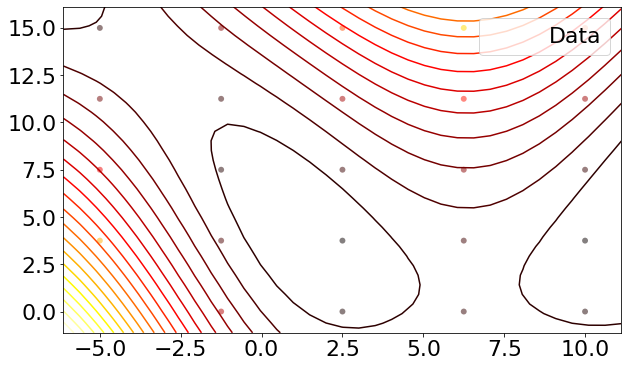

In [69]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
model.plot(ax=ax)

mlai.write_figure('branin-gp-optimized-fit.svg', directory='./gp')

<img src="https://mlatcl.github.io/mlphysical/./slides/diagrams//gp/branin-gp-optimized-fit.svg" class="" width="80%" style="vertical-align:middle;">

Figure: <i>A Gaussian process fit to the Branin test function, used to
assess the mean of the function by emulation.</i>

Finally, we can compute the mean of the model predictions using very
many Monte Carlo samples.

Note, that in this example, because we’re using a test function, we
could simply have done the Monte Carlo estimation directly on the Branin
function. However, imagine instead that we were trying to understand the
results of a complex computational fluid dynamics simulation, where each
run of the simulation (which is equivalent to our test function) took
many hours. In that case the advantage of the emulator is clear.

In [70]:
# Compute the mean of model prediction on 1e5 Monte Carlo samples
Xp = np.random.uniform(size=(int(1e5),2))
Xp[:,0] = Xp[:,0]*15-5
Xp[:,1] = Xp[:,1]*15
mu, var = model.predict(Xp)
print('The estimate of the mean of the Branin function is {mean}'.format(mean=np.mean(mu)))

The estimate of the mean of the Branin function is 57.989301445816345


### Exercise 1

Now think about how to make use of the variance estimation from the
Gaussian process to obtain error bars around your estimate.

In [71]:
# Write your answer to Exercise 1 here






### Exercise 2

You’ve seen how the Monte Carlo estimates work with the Gaussian
process. Now make your estimate of the probability that the Branin
function is greater than 200 with the uniform random inputs.

In [72]:
# Write your answer to Exercise 2 here






## Uncertainty Quantification and Design of Experiments

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/uq-sampling-history-doe.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/uq-sampling-history-doe.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

We’re introducing you to the optimization and analysis of real-world
models through emulation, this domain is part of a broader field known
as surrogate modelling.

Although we’re approaching this from the machine learning perspective,
with a computer-scientist’s approach, you won’t be surprised to find out
that this field is not new and there are a range of research groups
interested in this domain.

We’ve been focussing on *active* experimental design. In particular, the
case where we are sequentially selecting points to run our simulation
based on previous results.

Here, we pause for a moment and cover approaches to *passive*
experimental design. Almost all the emulation examples we’ve looked at
so far need some initial points to ‘seed’ the emulator. Selecting these
is also a task of experimental design, but one we perform without
running our simulator.

This type of challenge, of where to run the simulation to get the answer
you require is an old challenge. One classic paper, McKay et al. (1979),
reviews three different methods for designing these inputs. They are
*random sampling*, *stratified sampling* and *Latin hypercube sampling*.

> Let the input values $\mathbf{ x}_1, \dots, \mathbf{ x}_n$ be a random
> sample from $f(\mathbf{ x})$. This method of sampling is perhaps the
> most obvious, and an entire body of statistical literature may be used
> in making inferences regarding the distribution of $Y(t)$.

> Using stratified sampling, all areas of the sample space of
> $\mathbf{ x}$ are represented by input values. Let the sample space
> $S$ of $\mathbf{ x}$ be partitioned into $I$ disjoint strata $S_t$.
> Let $\pi = P(\mathbf{ x}\in S_i)$ represent the size of $S_i$. Obtain
> a random sample $\mathbf{ x}_{ij}$, $j = 1, \dots, n$ from $S_i$. Then
> of course the $n_i$ sum to $n$. If $I = 1$, we have random sampling
> over the entire sample space.

> The same reasoning that led to stratified sampling, ensuring that all
> portions of $S$ were sampled, could lead further. If we wish to ensure
> also that each of the input variables $\mathbf{ x}_k$ has all portions
> of its distribution represented by input values, we can divide the
> range of each $\mathbf{ x}_k$ into $n$ strata of equal marginal
> probability $1/n$, and sample once from each stratum. Let this sample
> be $\mathbf{ x}_{kj}$, $j = 1, \dots, n$. These form the
> $\mathbf{ x}_k$ component, $k = 1, \dots , K$, in $\mathbf{ x}_i$,
> $i = 1, \dots, n$. The components of the various $\mathbf{ x}_k$’s are
> matched at random. This method of selecting input values is an
> extension of quota sampling (Steinberg 1963), and can be viewed as a
> $K$-dimensional extension of Latin square sampling (Raj 1968).

The paper’s rather dated reference to “Output from a Computer Code” does
carry forward through this literature, which has continued to be a focus
of interest for statisticians. [Tony
O’Hagan](http://www.tonyohagan.co.uk/academic/), who was a colleague in
Sheffield but is also one of the pioneers of Gaussian process models was
developing these methods when I first arrived there (Kennedy and
O’Hagan, 2001), and continued with a large EPSRC funded project for
managing uncertainty in computational models, <http://www.mucm.ac.uk/>.
You can see a list of [their technical reports
here](http://www.mucm.ac.uk/Pages/Dissemination/TechnicalReports.html).

Another important group based in France is the “MASCOT-NUM Research
Group,” <https://www.gdr-mascotnum.fr/>. These researchers bring
together statisticians, applied mathematicians and engineers in solving
these problems.

## Emukit Playground

<span class="editsection-bracket" style="">\[</span><span
class="editsection"
style=""><a href="https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/emukit-playground.md" target="_blank" onclick="ga('send', 'event', 'Edit Page', 'Edit', 'https://github.com/lawrennd/talks/edit/gh-pages/_uq/includes/emukit-playground.md', 13);">edit</a></span><span class="editsection-bracket" style="">\]</span>

<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip34">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Leah Hirst

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/person-placeholder.jpg" clip-path="url(#clip34)"/>

</svg>
<svg viewBox="0 0 200 200" style="width:15%">

<defs> <clipPath id="clip35">

<style>
circle {
  fill: black;
}
</style>

<circle cx="100" cy="100" r="100"/> </clipPath> </defs>

<title>

Cliff McCollum

</title>

<image preserveAspectRatio="xMinYMin slice" width="100%" xlink:href="https://mlatcl.github.io/mlphysical/./slides/diagrams//people/cliff-mccollum.jpg" clip-path="url(#clip35)"/>

</svg>

Emukit playground is a software toolkit for exploring the use of
statistical emulation as a tool. It was built by [Leah
Hirst](https://www.linkedin.com/in/leahhirst/), during her software
engineering internship at Amazon and supervised by [Cliff
McCollum](https://www.linkedin.com/in/cliffmccollum/).

<img class="" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//uq/emukit-playground.png" style="width:80%">

Figure: <i>Emukit playground is a tutorial for understanding the
simulation/emulation relationship.
<https://amzn.github.io/emukit-playground/></i>

<img class="negate" src="https://mlatcl.github.io/mlphysical/./slides/diagrams//uq/emukit-playground-bayes-opt.png" style="width:80%">

Figure: <i>Tutorial on Bayesian optimization of the number of taxis
deployed from Emukit playground.
<https://amzn.github.io/emukit-playground/#!/learn/bayesian_optimization></i>

You can explore Bayesian optimization of a taxi simulation.

### Exercise 3

You now know enough to build a simple emulation. To test your knowledge
have a go at cobmining GPy with Thomas House’s herd immunity simulation.
Can you build a Gaussian process emulator of the simulation? Don’t spent
do long on this exercise. The idea is just to consolidate things like
what the inputs and outputs should be.

In [73]:
# Write your answer to Exercise 3 here






## Conclusions

We summarized the different types of simulation into roughly three
groups. Firstly, those based on physical laws in the form of
differential equations. Examples include certain compartmental
epidemiological models, climate models and weather models. Secondly,
discrete event simulations. These simulations often run to a ‘clock,’
where updates to the state are taken in turns. The Game of Life is an
example of this type of simulation, and Formula 1 models of race
strategy also use this approach. There is another type of discrete event
simulation that doesn’t use a turn-based approach but waits for the next
event. The [Gillespie
algorithm](https://en.wikipedia.org/wiki/Gillespie_algorithm) is an
example of such an approach but we didn’t cover it here. Finally, we
realized that general computer code bases are also simulations. If a
company has a large body of code, and particularly if it’s hosted within
a streaming environment (such as Apache Kafka), it’s possible to back
test the code with different inputs. Such backtests can be viewed as
simulations, and in the case of large bodies of code (such as the code
that manages Amazon’s automated buying systems) the back tests can be
slow and could also benefit from emulation.

We’ve introduced emulation as a way of dealing with different fidelities
of simulations and removing the computational demands that come with
them. We’ve highlighted how emulation can be deployed and introduced the
`GPy` software for Gaussian process modelling.

## Thanks!

For more information on these subjects and more you might want to check
the following resources.

-   twitter: [@lawrennd](https://twitter.com/lawrennd)
-   podcast: [The Talking Machines](http://thetalkingmachines.com)
-   newspaper: [Guardian Profile
    Page](http://www.theguardian.com/profile/neil-lawrence)
-   blog:
    [http://inverseprobability.com](http://inverseprobability.com/blog.html)

## References

Borchert, T., 2020. Milan: An evolution of data-oriented programming.

Byrd, R.H., Lu, P., Nocedal, J., 1995. A limited memory algorithm for
bound constrained optimization. SIAM Journal on Scientific and
Statistical Computing 16, 1190–1208.

Joshi, R., 2007. A loosely-coupled real-time SOA. Real-Time Innovations
Inc.

Kennedy, M.C., O’Hagan, A., 2001. Bayesian calibration of computer
models. Journal of the Royal Statistical Society: Series B (Statistical
Methodology) 63, 425–464. <https://doi.org/10.1111/1467-9868.00294>

Lawrence, N.D., 2019. Modern data oriented programming.

Lawrence, N.D., 2017. Data readiness levels. ArXiv.

Lawrence, N.D., Montgomery, J., Paquet, U., 2020. Organisational data
maturity. The Royal Society.

McKay, M.D., Beckman, R.J., Conover, W.J., 1979. A comparison of three
methods for selecting values of input variables in the analysis of
output from a computer code. Technometrics 21, 239–245.

Stromquist, W.R., 1984. Packing unit squares inside squares, III. Daniel
H. Wagner Associates.

The DELVE Initiative, 2020b. Data readiness: Lessons from an emergency.
The Royal Society.

The DELVE Initiative, 2020a. Test, trace, isolate. The Royal Society.

Vorhemus, C., Schikuta, E., 2017. A data-oriented architecture for
loosely coupled real-time information systems, in: Proceedings of the
19th International Conference on Information Integration and Web-Based
Applications & Services, iiWAS ’17. Association for Computing Machinery,
New York, NY, USA, pp. 472–481.
<https://doi.org/10.1145/3151759.3151770>